# Import & Files

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import csv
import os
import time
from numba import njit, prange
from sklearn.decomposition import PCA

In [104]:
def set_seed(seed=42):
    """
    Sets the seed for reproducibility across standard libraries.
    """
    # Base Python random
    random.seed(seed)
    
    # NumPy (Crucial for latent factor initialization P, Q, W)
    np.random.seed(seed)
    
    # Environment variable for Python hashing
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"Global seed set to: {seed}")

# Execute the seed setting
set_seed(42)

Global seed set to: 42


In [62]:
# change to project directory
%cd "C:/Users/moesa/Projects/ml_at_scale/"

C:\Users\moesa\Projects\ml_at_scale


In [63]:
# Files within the project directory
ratings100k = "ml-latest-small/ratings.csv"

ratings32m = "ml-32m/ratings.csv"
movies32m  = "ml-32m/movies.csv"

In [64]:
# Load movie metadata for display
movies = pd.read_csv(movies32m)
print(f"Loaded {len(movies)} movies from movies.csv")

Loaded 87585 movies from movies.csv


# 1. Optimised Loading (CSR & CSC) + Train/Test Split

In [105]:
# @title
class RatingsCSR:
    """
    Optimised dual CSR index using lexsort and bincount (NumPy).
    """

    def __init__(self, ratings_file, test_ratio=0.05, seed=42):
        self.ratings_file = ratings_file
        self.test_ratio = test_ratio
        self.seed = seed

        # Attributes to store flat data for EDA
        self.users = None
        self.movies = None
        self.ratings = None

        # Data containers
        self.user_pairs_train = None
        self.user_indptr_train = None
        self.user_pairs_test = None
        self.user_indptr_test = None

        self.movie_pairs_train = None
        self.movie_indptr_train = None
        self.movie_pairs_test = None
        self.movie_indptr_test = None

        self.n_users = 0
        self.n_movies = 0

    def load(self):
        """Vectorized load function."""
        print("Reading CSV data...")

        # Load data into a numpy array
        # usecols=(0, 1, 2) reads userId, movieId, rating (skips timestamp)
        raw_data = np.loadtxt(self.ratings_file, delimiter=',', skiprows=1, usecols=(0, 1, 2))

        # Separate columns and Zero-index IDs
        # Assuming inputs are floats from loadtxt, cast to appropriate types
        self.users = raw_data[:, 0].astype(np.int32) - 1
        self.movies = raw_data[:, 1].astype(np.int32) - 1
        self.ratings = raw_data[:, 2].astype(np.float32)

        # Determine dimensions
        self.n_users = np.max(self.users) + 1
        self.n_movies = np.max(self.movies) + 1

        print(f"Users: {self.n_users}, Movies: {self.n_movies}, Ratings: {len(self.ratings)}")

        # Train/Test Split
        print("Splitting train/test...")
        np.random.seed(self.seed)

        # Generate mask
        mask_test = np.random.rand(len(self.ratings)) < self.test_ratio
        mask_train = ~mask_test

        # Apply mask
        u_train, m_train, r_train = self.users[mask_train], self.movies[mask_train], self.ratings[mask_train]
        u_test, m_test, r_test    = self.users[mask_test], self.movies[mask_test], self.ratings[mask_test]
        print(f"Train: {len(u_train)}, Test: {len(u_test)}")

        # 4. Build CSR structures
        print("Building CSRs...")

        def build_csr_numpy(primary_ids, secondary_ids, ratings, n_entities):
            """
            Builds CSR arrays using lexsort and bincount.
            primary_ids: The entity we are grouping by (eg. users in User-Indexing)
            secondary_ids: The entity inside the list (eg. movies in User-Indexing)
            """
            # We want to sort by Primary (Primary Key), then Secondary (for order)
            # So we pass (Secondary, Primary)
            sorter = np.lexsort((secondary_ids, primary_ids))

            sorted_secondary = secondary_ids[sorter]
            sorted_ratings = ratings[sorter]
            sorted_primary = primary_ids[sorter]

            # Create structured array for pairs
            pairs = np.zeros(len(ratings), dtype=[('idx', np.int32), ('rating', np.float32)])
            pairs['idx'] = sorted_secondary
            pairs['rating'] = sorted_ratings

            # Calculate Indptr using bincount (gives the number of occurrences of each ID)
            counts = np.bincount(sorted_primary, minlength=n_entities)

            indptr = np.zeros(n_entities + 1, dtype=np.int32)
            indptr[1:] = np.cumsum(counts)

            return pairs, indptr

        # Construct User CSRs (Group by User, order by Movie)
        self.user_pairs_train, self.user_indptr_train = build_csr_numpy(
            u_train, m_train, r_train, self.n_users
        )
        self.user_pairs_test, self.user_indptr_test = build_csr_numpy(
            u_test, m_test, r_test, self.n_users
        )

        # Construct Movie CSRs (Group by Movie, order by User)
        self.movie_pairs_train, self.movie_indptr_train = build_csr_numpy(
            m_train, u_train, r_train, self.n_movies
        )
        self.movie_pairs_test, self.movie_indptr_test = build_csr_numpy(
            m_test, u_test, r_test, self.n_movies
        )

        print("Done!")
        return self

    def get_user_ratings_train(self, user_idx):
        start, end = self.user_indptr_train[user_idx], self.user_indptr_train[user_idx + 1]
        return self.user_pairs_train[start:end]

    def get_user_ratings_test(self, user_idx):
        start, end = self.user_indptr_test[user_idx], self.user_indptr_test[user_idx + 1]
        return self.user_pairs_test[start:end]

    def get_movie_ratings_train(self, movie_idx):
        start, end = self.movie_indptr_train[movie_idx], self.movie_indptr_train[movie_idx + 1]
        return self.movie_pairs_train[start:end]

    def get_movie_ratings_test(self, movie_idx):
        start, end = self.movie_indptr_test[movie_idx], self.movie_indptr_test[movie_idx + 1]
        return self.movie_pairs_test[start:end]

    def get_movie_rating_counts(self):
        # Vectorized count calculation
        train_counts = np.diff(self.movie_indptr_train)
        test_counts = np.diff(self.movie_indptr_test)
        return train_counts + test_counts

In [106]:
data100k = RatingsCSR(ratings_file=ratings100k,
                      test_ratio=0.2,
                      seed=42)
data100k.load()

Reading CSV data...
Users: 610, Movies: 193609, Ratings: 100836
Splitting train/test...
Train: 80651, Test: 20185
Building CSRs...
Done!


In [107]:
data32m = RatingsCSR(ratings_file=ratings32m,
                     test_ratio=0.1,
                     seed=42)

data32m.load()

Reading CSV data...
Users: 200948, Movies: 292757, Ratings: 32000204
Splitting train/test...
Train: 28800054, Test: 3200150
Building CSRs...
Done!


# 2. Exploratory Data Analysis

In [68]:
def run_eda(users, movies, scores):
    """
    Performs optimized EDA for the MovieLens 32M dataset.

    Generates high-quality PDF visualizations:
    1. Count by Rating Value
    2. Top 20 Most Active Users
    3. Combined Power Law Distribution
    """
    print("Pre-calculating global statistics...")
    sns.set_theme(style="whitegrid")

    # Efficiently calculate frequencies
    user_ids, user_counts = np.unique(users, return_counts=True)
    movie_ids, movie_counts = np.unique(movies, return_counts=True)
    rating_vals, rating_freqs = np.unique(scores, return_counts=True)

    def save_fig(name):
        """Helper to save plots consistently in PDF format."""
        plt.tight_layout()
        plt.savefig(f"{name}.pdf", format="pdf", bbox_inches="tight")
        print(f"Generated: {name}.pdf")
        plt.close()

    # FIGURE 1: Count by Rating Value
    print("Generating Figure 1: Rating Value Counts...")
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette("viridis", len(rating_vals))
    
    ax.bar(
        rating_vals, rating_freqs, color=colors, 
        edgecolor='black', linewidth=0.5
    )
    
    # Labels and font sizes
    ax.set_title('Count by Rating Value', fontsize=16, fontweight='bold')
    ax.set_xlabel('Rating', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks(rating_vals)

    # Text annotation style
    for rating, count in zip(rating_vals, rating_freqs):
        ax.text(
            rating, count, f'{count/1e6:.1f}M', 
            ha='center', va='bottom', fontsize=9
        )
    
    save_fig("rating_value_counts")

    # FIGURE 2: Top 20 Most Active Users
    print("Generating Figure 2: Top 20 Users...")
    fig, ax = plt.subplots(figsize=(10, 8))
    top_idx = np.argsort(user_counts)[-20:]

    ax.barh(
        np.arange(20), user_counts[top_idx], 
        color=sns.color_palette("mako_r", 20), edgecolor="black"
    )
    ax.set_yticks(np.arange(20))
    ax.set_yticklabels([f"User {i}" for i in user_ids[top_idx]])
    ax.set_title("Top 20 Most Active Users", fontsize=16, fontweight="bold")
    ax.set_xlabel("Number of Ratings Provided", fontsize=12)
    ax.invert_yaxis()

    save_fig("top_20_users")

    # FIGURE 3: Combined Power Law
    print("Generating Figure 3: Combined Power Law...")
    u_vals, u_freq = np.unique(user_counts, return_counts=True)
    m_vals, m_freq = np.unique(movie_counts, return_counts=True)

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.scatter(
        m_vals, m_freq, c="#2ecc71", s=60, alpha=0.5, 
        label="Movies", edgecolors="#27ae60", zorder=2
    )
    ax.scatter(
        u_vals, u_freq, c="#3498db", s=60, alpha=0.5, 
        label="Users", edgecolors="#2980b9", zorder=3
    )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Degree (Number of Ratings)", fontsize=14, fontweight="bold")
    ax.set_ylabel("Frequency (Log Scale)", fontsize=14, fontweight="bold")
    ax.set_title(
        "Power Law Distribution: Users and Movies", 
        fontsize=18, fontweight="bold", pad=20
    )
    ax.legend(fontsize=13, frameon=True, shadow=True)

    ax.text(
        0.02, 0.02, 
        "Note: Users with <20 ratings are excluded by MovieLens criteria",
        transform=ax.transAxes, fontsize=11, color="#7f8c8d", fontstyle="italic"
    )

    save_fig("powerlaw_combined")

    # Console Output for LaTeX Table 1
    total_possible = len(user_ids) * len(movie_ids)
    sparsity = 100 * (1 - len(scores) / total_possible)

    print("\nSummary Stats for Table 1:")
    print(f"Total Ratings:      {len(scores):,}")
    print(f"Unique Users:       {len(user_ids):,}")
    print(f"Unique Movies:      {len(movie_ids):,}")
    print(f"Avg Ratings/User:   {user_counts.mean():.1f}")
    print(f"Avg Ratings/Movie:  {movie_counts.mean():.1f}")
    print(f"Sparsity:           {sparsity:.4f}%")

In [69]:
run_eda(users = data32m.users,
        movies = data32m.movies,
        scores = data32m.ratings)

Pre-calculating global statistics...
Generating Figure 1: Rating Value Counts...
Generated: rating_value_counts.pdf
Generating Figure 2: Top 20 Users...
Generated: top_20_users.pdf
Generating Figure 3: Combined Power Law...
Generated: powerlaw_combined.pdf

Summary Stats for Table 1:
Total Ratings:      32,000,204
Unique Users:       200,948
Unique Movies:      84,432
Avg Ratings/User:   159.2
Avg Ratings/Movie:  379.0
Sparsity:           99.8114%


# 3. Supporting Functions (Metrics, Ploting, Recommendations, Polarisation)

In [70]:
@njit(parallel=True, fastmath=True)
def _compute_metrics_jit(ptr, idx, ratings, P, Q, bu, bi, mu):
    """
    High-performance Numba engine for metrics.
    Uses parallel reduction to calculate SSE and RMSE across all ratings.
    """
    sse = 0.0
    count = 0
    n_users = len(ptr) - 1

    for m in prange(n_users):
        start, end = ptr[m], ptr[m+1]
        if start == end:
            continue

        user_vec = P[m]
        user_bias = bu[m]

        user_sse = 0.0
        for i in range(start, end):
            movie_idx = idx[i]
            # Prediction: mu + b_u + b_i + p_u · q_i
            pred = mu + user_bias + bi[movie_idx] + user_vec.dot(Q[movie_idx])
            user_sse += (ratings[i] - pred) ** 2

        sse += user_sse
        count += (end - start)

    rmse = np.sqrt(sse / count) if count > 0 else 0.0
    return sse, rmse

def compute_metrics_csr(data_csr, P, Q, bu, bi, mu, train=True):
    """
    Clean wrapper for computing loss and RMSE on train or test set.
    Directly interfaces with the RatingsCSR object and the Numba engine.
    """
    # Select the appropriate CSR pointers and data
    if train:
        ptr = data_csr.user_indptr_train
        idx = data_csr.user_pairs_train['idx']
        ratings = data_csr.user_pairs_train['rating']
    else:
        ptr = data_csr.user_indptr_test
        idx = data_csr.user_pairs_test['idx']
        ratings = data_csr.user_pairs_test['rating']

    # Call the high-speed engine
    sse, rmse = _compute_metrics_jit(ptr, idx, ratings, P, Q, bu, bi, mu)

    return sse, rmse

In [71]:
def plot_training_results(results, model_name="Model"):
    """
    Plots the NLL and RMSE convergence history.

    Saves high-quality PDF visualizations for LaTeX reports:
    1. Negative Log Likelihood (NLL) convergence.
    2. RMSE convergence (Training vs. Testing).
    """
    sns.set_theme(style="whitegrid")
    model_id = model_name.lower().replace(" ", "_")

    # --- Figure 1: Negative Log Likelihood (NLL) ---
    loss_history = results.get('loss_history', [])
    if loss_history:
        plt.figure(figsize=(10, 6))
        plt.plot(
            loss_history, color='#1f77b4', linewidth=2.5, 
            label='Objective Function (SSE-proportional)'
        )

        final_loss = loss_history[-1]
        plt.scatter(
            len(loss_history) - 1, final_loss, 
            color='#1f77b4', s=60, zorder=5
        )
        plt.annotate(
            f'{final_loss:.2e}', 
            xy=(len(loss_history) - 1, final_loss),
            xytext=(10, 0), textcoords='offset points',
            va='center', fontweight='bold', color='#1f77b4'
        )

        plt.title(
            f"Negative Log Likelihood: {model_name} Convergence", 
            fontsize=15, fontweight='bold', pad=20
        )
        plt.xlabel("Iteration", fontsize=12, fontweight='bold')
        plt.ylabel("NLL (Log Scale Simulation)", fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f"{model_id}_nll.pdf", format='pdf', bbox_inches='tight')
        print(f"Generated: {model_id}_nll.pdf")
        plt.show()

    # --- Figure 2: RMSE (Train vs Test) ---
    train_rmse = results.get('rmse_train_history', [])
    test_rmse = results.get('rmse_test_history', [])

    if train_rmse or test_rmse:
        plt.figure(figsize=(10, 6))
        
        if train_rmse:
            plt.plot(
                train_rmse, color='#ff7f0e', marker='o', markersize=4,
                linewidth=2, label='Train RMSE', alpha=0.7
            )
        
        if test_rmse:
            plt.plot(
                test_rmse, color='#2ca02c', marker='^', markersize=4,
                linewidth=2, label='Test RMSE'
            )

            # Highlight the global minimum for the test set
            min_rmse = min(test_rmse)
            min_idx = test_rmse.index(min_rmse)
            plt.scatter(
                min_idx, min_rmse, color='#d62728', 
                s=70, zorder=10, marker='o', edgecolors='black'
            )
            plt.annotate(
                f'Optimal RMSE: {min_rmse:.4f}', 
                xy=(min_idx, min_rmse),
                xytext=(0, 15), textcoords='offset points',
                ha='center', color='#d62728', fontweight='black', fontsize=11
            )

        plt.title(
            f"RMSE Convergence: {model_name} Training Profile", 
            fontsize=15, fontweight='bold', pad=20
        )
        plt.xlabel("Iteration", fontsize=12, fontweight='bold')
        plt.ylabel("Root Mean Square Error", fontsize=12, fontweight='bold')
        plt.legend(frameon=True, loc='upper right', shadow=True)
        
        plt.tight_layout()
        plt.savefig(f"{model_id}_rmse.pdf", format='pdf', bbox_inches='tight')
        print(f"Generated: {model_id}_rmse.pdf")
        plt.show()

In [72]:
def recommend_for_new_user(dummy_ratings_ids, item_vectors, item_biases,
                           global_mean, data_csr, movies_df,
                           lambd=0.002, tau=0.05, gamma=0.015,
                           top_k=10, min_ratings=100, bias_weight=0.05):
    """
    Solves for a new user's latent factors and generates personalized recommendations.

    Logic:
    1. Computes User Bias
    2. Computes User Latent Vector
    3. Scores all movies with a popularity penalty
    4. Filters and displays results using optimized metadata lookups
    """
    K = item_vectors.shape[1]
    n_ratings = len(dummy_ratings_ids)
    if n_ratings == 0:
        print("Error: No ratings provided.")
        return None

    # 1. Solve for Dummy User Parameters
    movie_indices = np.array([idx for idx, _ in dummy_ratings_ids], dtype=np.int32)
    ratings = np.array([r for _, r in dummy_ratings_ids], dtype=np.float32)

    # User Bias
    residuals_bias = ratings - global_mean - item_biases[movie_indices]
    user_bias = (lambd * np.sum(residuals_bias)) / (lambd * n_ratings + gamma)

    # User Latent Vector
    residuals_latent = ratings - global_mean - user_bias - item_biases[movie_indices]
    V_batch = item_vectors[movie_indices, :]
    A = lambd * (V_batch.T @ V_batch) + tau * np.eye(K, dtype=np.float32)
    b = lambd * (V_batch.T @ residuals_latent)
    user_vector = np.linalg.solve(A, b)

    # 2. Vectorized Scoring
    scores = global_mean + (item_vectors @ user_vector) + (bias_weight * item_biases)

    # 3. Filtering & Ranking
    # Filter by minimum popularity threshold
    movie_rating_counts = data_csr.get_movie_rating_counts()
    scores[movie_rating_counts < min_ratings] = -np.inf

    # Filter out movies already rated
    scores[movie_indices] = -np.inf

    top_idx = np.argsort(scores)[::-1][:top_k]
    top_scores = scores[top_idx]

    # 4. Optimised Display
    # Pre-index movies for O(1) lookup
    meta = movies_df.set_index('movieId')

    print(f"RECOMMENDATIONS FOR NEW USER ({n_ratings} Seed Ratings)")
    print(f"Calculated Bias: {user_bias:.4f} | Vector Norm: {np.linalg.norm(user_vector):.4f}")

    for i, (idx, score) in enumerate(zip(top_idx, top_scores), 1):
        mid = idx + 1 # Convert back to 1-based MovieID
        try:
            row = meta.loc[mid]
            print(f"\n{i:2d}. [Score: {score:.4f}] {row['title']}")
            print(f"    Genres: {row['genres']}")
        except KeyError:
            print(f"{i:2d}. [Score: {score:.4f}] Movie ID {mid} (Metadata Missing)")

    return user_vector, user_bias

In [73]:
def analyze_movie_polarity(item_vectors, data_csr, movies_df,
                           top_k=15, min_ratings=1000):
    """
    Identifies movies with the highest and lowest latent factor norms.
    - High norms: Polarizing items with strong specific traits.
    - Low norms: Generic/Safe items near the latent origin.
    """
    # Compute L2 Norms for all item trait vectors
    vector_norms = np.linalg.norm(item_vectors, axis=1)

    # Filtering for Statistical Significance
    movie_rating_counts = data_csr.get_movie_rating_counts()
    valid_mask = movie_rating_counts >= min_ratings

    # Apply mask using -inf so invalid items drop to the bottom of the sort
    filtered_norms = vector_norms.copy()
    filtered_norms[~valid_mask] = -np.inf

    # Most Polarizing (Highest Norms)
    most_polar_idx = np.argsort(filtered_norms)[::-1][:top_k]

    # Least Polarizing (Lowest Norms)
    valid_indices = np.where(valid_mask)[0]
    least_polar_idx = valid_indices[np.argsort(vector_norms[valid_indices])[:top_k]]

    # Optimised Display
    meta = movies_df.set_index('movieId')

    def print_block(indices, title_text):
        print(f"{title_text.upper()} (Min Ratings: {min_ratings:,})")
        for i, idx in enumerate(indices, 1):
            mid = idx + 1
            norm = vector_norms[idx]
            count = movie_rating_counts[idx]
            try:
                row = meta.loc[mid]
                print(f"\n{i:2d}. [Norm: {norm:6.4f}] {row['title']} ({count:,} ratings)")
                print(f"    Genres: {row['genres']}")
            except KeyError:
                print(f"{i:2d}. [Norm: {norm:6.4f}] Movie ID {mid} (Metadata Missing)")

    # Display Results
    print_block(most_polar_idx, "Most Polarizing Movies")
    print_block(least_polar_idx, "\nLeast Polarizing Movies")

    return (most_polar_idx, vector_norms[most_polar_idx]), (least_polar_idx, vector_norms[least_polar_idx])

# 4. Biases Only Model

Generated: baseline_bias-only_nll.pdf


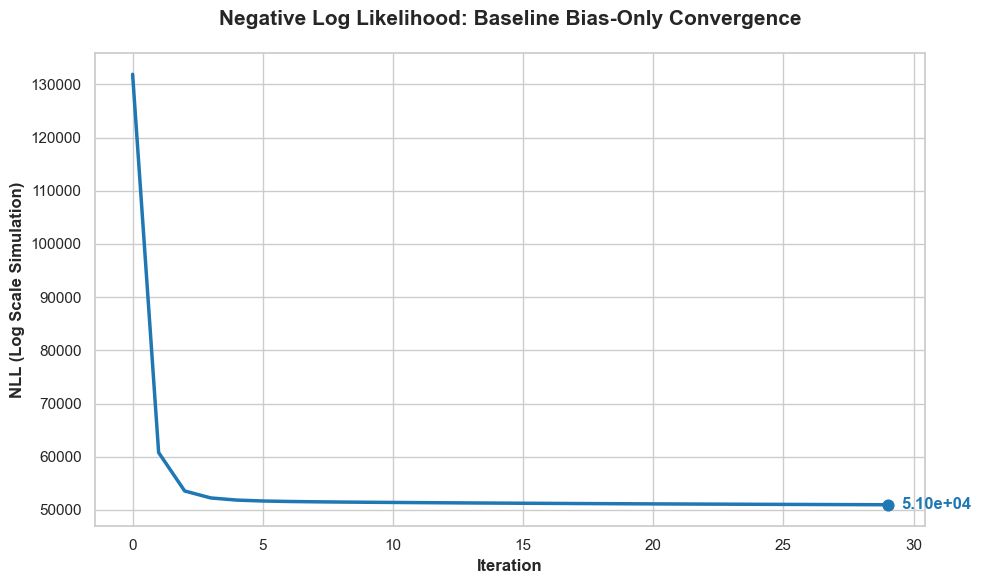

Generated: baseline_bias-only_rmse.pdf


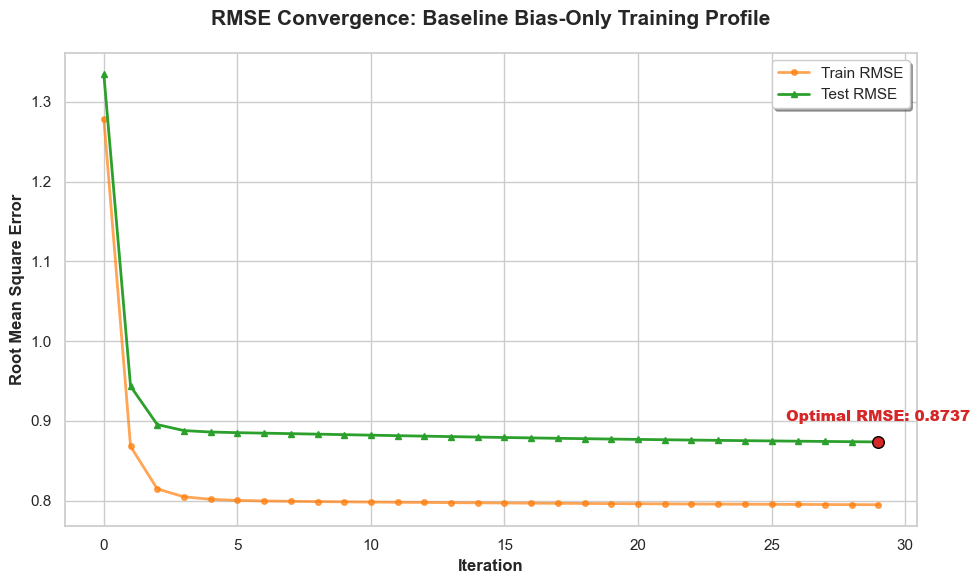

In [108]:
# Hyperparameters
lambd = 0.01
gamma = 0.01
alpha = 0.5
num_iters = 30

# Initialize parameters
M = data100k.n_users
N = data100k.n_movies
user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)

# For plotting
loss_hist = []
train_rmse_hist = []
test_rmse_hist  = []

for i in range(num_iters):
    # Update User Biases
    for m in range(M):
        p = data100k.get_user_ratings_train(m)
        if len(p) > 0:
            b_star = (lambd * np.sum(p['rating'] - item_biases[p['idx']])) / (lambd * len(p) + gamma)
            user_biases[m] = (1 - alpha) * user_biases[m] + alpha * b_star

    # Update Item Biases
    for n in range(N):
        p = data100k.get_movie_ratings_train(n)
        if len(p) > 0:
            b_star = (lambd * np.sum(p['rating'] - user_biases[p['idx']])) / (lambd * len(p) + gamma)
            item_biases[n] = (1 - alpha) * item_biases[n] + alpha * b_star

    # Metrics
    sq_e_tr = 0.0
    count_tr = 0
    for m in range(M):
        p = data100k.get_user_ratings_train(m)
        if len(p) == 0: continue
        sq_e_tr += np.sum((p['rating'] - (user_biases[m] + item_biases[p['idx']]))**2)
        count_tr += len(p)

    sq_e_te = 0.0
    count_te = 0
    for m in range(M):
        p = data100k.get_user_ratings_test(m)
        if len(p) == 0: continue
        sq_e_te += np.sum((p['rating'] - (user_biases[m] + item_biases[p['idx']]))**2)
        count_te += len(p)

    loss_hist.append(sq_e_tr)
    train_rmse_hist.append(np.sqrt(sq_e_tr/count_tr))
    test_rmse_hist.append(np.sqrt(sq_e_te/count_te))

# Plot results
plot_training_results({
    'loss_history': loss_hist,
    'rmse_train_history': train_rmse_hist,
    'rmse_test_history': test_rmse_hist
}, model_name="Baseline Bias-Only")

# 5. Numba Optimised and Parallelised ALS

In [109]:
@njit(parallel=True, fastmath=True)
def als_step_user_numba(M, K, user_indptr, user_indices, user_ratings,
                        Q, bi, P, bu,
                        lambd, gamma, tau, global_mean):
    """
    Optimized User Update Step.
    """
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    for m in prange(M):
        start, end = user_indptr[m], user_indptr[m+1]
        n_ratings = end - start
        if n_ratings == 0: continue

        idx = user_indices[start:end]
        r = user_ratings[start:end]
        V_batch = Q[idx]  # Item vectors for items rated by user m

        # 1. Update User Bias (b_u)
        # Residual includes current latent interaction
        dots = V_batch.dot(P[m])
        res_bias = r - global_mean - bi[idx] - dots
        bu[m] = (lambd * np.sum(res_bias)) / (lambd * n_ratings + gamma)

        # 2. Update User Latent Vector (p_u)
        # Residual accounts for the newly updated bias
        res_latent = r - global_mean - bu[m] - bi[idx]

        # Solve Ridge Regression: (lambda * V^T @ V + tau * I) * p_u = lambda * V^T @ res
        A = lambd * (V_batch.T @ V_batch) + reg_matrix
        b = lambd * (V_batch.T @ res_latent)
        P[m] = np.linalg.solve(A, b)

@njit(parallel=True, fastmath=True)
def als_step_item_numba(N, K, item_indptr, item_indices, item_ratings,
                        P, bu, Q, bi,
                        lambd, gamma, tau, global_mean):
    """
    Optimized Item Update Step (Symmetrical to User Step).
    """
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    for n in prange(N):
        start, end = item_indptr[n], item_indptr[n+1]
        n_ratings = end - start
        if n_ratings == 0: continue

        idx = item_indices[start:end]
        r = item_ratings[start:end]
        U_batch = P[idx]  # User vectors for users who rated item n

        # 1. Update Item Bias (b_i)
        dots = U_batch.dot(Q[n])
        res_bias = r - global_mean - bu[idx] - dots
        bi[n] = (lambd * np.sum(res_bias)) / (lambd * n_ratings + gamma)

        # 2. Update Item Latent Vector (q_i)
        res_latent = r - global_mean - bu[idx] - bi[n]
        A = lambd * (U_batch.T @ U_batch) + reg_matrix
        b = lambd * (U_batch.T @ res_latent)
        Q[n] = np.linalg.solve(A, b)

In [110]:
def train_als_csr(data_csr, K=20, lambd=0.002, gamma=0.0125, tau=0.05,
                  num_iters=30, verbose=True):
    """
    Complete ALS Training Pipeline for MovieLens 32M.
    Utilizes optimized Numba steps and standardized metrics tracking.
    """
    M, N = data_csr.n_users, data_csr.n_movies
    dtype = np.float32

    # 1. Initialization
    global_mean = dtype(np.mean(data_csr.user_pairs_train['rating']))
    bu = np.zeros(M, dtype=dtype)
    bi = np.zeros(N, dtype=dtype)
    P = (np.random.randn(M, K) * 0.01).astype(dtype) # User Latent Matrix
    Q = (np.random.randn(N, K) * 0.01).astype(dtype) # Item Latent Matrix

    # Extract Numba-compatible raw arrays
    u_ptr, u_idx, u_r = data_csr.user_indptr_train, data_csr.user_pairs_train['idx'], data_csr.user_pairs_train['rating'].astype(dtype)
    m_ptr, m_idx, m_r = data_csr.movie_indptr_train, data_csr.movie_pairs_train['idx'], data_csr.movie_pairs_train['rating'].astype(dtype)

    history = {'loss_history': [], 'rmse_train_history': [], 'rmse_test_history': []}

    if verbose:
        print(f"Starting ALS Training | K={K}, λ={lambd}, γ={gamma}, τ={tau}")
        print(f"Global Mean: {global_mean:.4f}")

    start_time = time.time()
    for i in range(num_iters):
        # Perform Alternating Steps
        als_step_user_numba(M, K, u_ptr, u_idx, u_r, Q, bi, P, bu, lambd, gamma, tau, global_mean)
        als_step_item_numba(N, K, m_ptr, m_idx, m_r, P, bu, Q, bi, lambd, gamma, tau, global_mean)

        # Compute Metrics (NLL/SSE and RMSE)
        train_sse, train_rmse = compute_metrics_csr(data_csr, P, Q, bu, bi, global_mean, train=True)
        _, test_rmse = compute_metrics_csr(data_csr, P, Q, bu, bi, global_mean, train=False)

        history['loss_history'].append(train_sse)
        history['rmse_train_history'].append(train_rmse)
        history['rmse_test_history'].append(test_rmse)

        if verbose and ((i + 1) % 5 == 0 or i == 0):
            print(f"Iteration {i+1:2d}/{num_iters} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

    if verbose:
        print(f"Training Complete. Total Time: {time.time() - start_time:.2f}s")

    return {
        'P': P, 'Q': Q, 'bu': bu, 'bi': bi,
        'global_mean': global_mean,
        **history
    }

# 6. Hyperparameter Tuning (λ, τ, γ)

In [111]:
# HIGH-PERFORMANCE SEARCH ENGINE
@njit(parallel=True, fastmath=True)
def _run_single_trial(u_ptr, u_idx, u_r, m_ptr, m_idx, m_r,
                      l, g, t, K, iters, n_u, n_i, mu):
    """
    Hardened JIT solver.
    Uses explicit dot product logic to prevent Numba 'ravel' lowering errors.
    """
    rows_p = np.intp(n_u)
    cols_p = np.intp(n_i)
    factors_k = np.intp(K)

    # Initialize weights
    P = (np.random.standard_normal((rows_p, factors_k)) * 0.01).astype(np.float32)
    Q = (np.random.standard_normal((cols_p, factors_k)) * 0.01).astype(np.float32)

    bu = np.zeros(rows_p, dtype=np.float32)
    bi = np.zeros(cols_p, dtype=np.float32)
    I_k = np.eye(factors_k, dtype=np.float32)

    for _ in range(iters):
        # --- User Update Phase ---
        for m in prange(rows_p):
            s, e = u_ptr[m], u_ptr[m+1]
            if e <= s: continue

            idx, r = u_idx[s:e], u_r[s:e]
            V = Q[idx]

            # Use np.dot with explicit indexing to keep dimensions clear
            # This prevents the parallel-lowering 'ravel' error
            pred = np.zeros(len(idx), dtype=np.float32)
            for i in range(len(idx)):
                for k in range(factors_k):
                    pred[i] += V[i, k] * P[m, k]

            res_b = r - mu - bi[idx] - pred
            bu[m] = (l * np.sum(res_b)) / (l * (e - s) + g)

            # Latent Vector Update
            res_l = r - mu - bu[m] - bi[idx]
            A = l * (V.T @ V) + t * I_k
            b = l * (V.T @ res_l)
            P[m] = np.linalg.solve(A, b)

        # --- Item Update Phase ---
        for n in prange(cols_p):
            s, e = m_ptr[n], m_ptr[n+1]
            if e <= s: continue

            idx, r = m_idx[s:e], m_r[s:e]
            U = P[idx]

            pred = np.zeros(len(idx), dtype=np.float32)
            for i in range(len(idx)):
                for k in range(factors_k):
                    pred[i] += U[i, k] * Q[n, k]

            res_b = r - mu - bu[idx] - pred
            bi[n] = (l * np.sum(res_b)) / (l * (e - s) + g)

            A = l * (U.T @ U) + t * I_k
            b = l * (U.T @ (r - mu - bu[idx] - bi[n]))
            Q[n] = np.linalg.solve(A, b)

    return bu, bi, P, Q

# SEARCH ORCHESTRATION
def run_hyperparameter_search(data_csr, lambdas, gammas, taus, K=20, iters=5):
    """
    Systematically explores the hyperparameter space and logs results.
    """
    # Prepare Data
    u_ptr, u_idx, u_r = data_csr.user_indptr_train, data_csr.user_pairs_train['idx'], data_csr.user_pairs_train['rating']
    m_ptr, m_idx, m_r = data_csr.movie_indptr_train, data_csr.movie_pairs_train['idx'], data_csr.movie_pairs_train['rating']

    val_ptr = data_csr.user_indptr_test
    val_idx = data_csr.user_pairs_test['idx']
    val_r = data_csr.user_pairs_test['rating']

    n_u, n_i = data_csr.n_users, data_csr.n_movies
    mu = np.float32(np.mean(u_r))
    results = []

    print(f"{'='*60}\nGRID SEARCH OPTIMIZATION | K={K} | 32M Dataset\n{'='*60}")

    for l in lambdas:
        for g in gammas:
            for t in taus:
                # 1. Execute Trial
                bu, bi, P, Q = _run_single_trial(
                    u_ptr, u_idx, u_r.astype(np.float32),
                    m_ptr, m_idx, m_r.astype(np.float32),
                    l, g, t, K, iters, n_u, n_i, mu
                )

                # 2. Score on Validation Set (Reuse refactored metrics)
                _, val_rmse = _compute_metrics_jit(val_ptr, val_idx, val_r, P, Q, bu, bi, mu)

                results.append({'lambda': l, 'gamma': g, 'tau': t, 'val_rmse': val_rmse})
                print(f"λ:{l:.4f} | γ:{g:.4f} | τ:{t:.4f} >> RMSE: {val_rmse:.4f}")

    df = pd.DataFrame(results)
    best = df.loc[df['val_rmse'].idxmin()]
    print(f"\n{'='*60}\nBEST PARAMETERS: λ={best['lambda']:.4f}, γ={best['gamma']:.4f}, τ={best['tau']:.4f}\n{'='*60}")
    return df, best

# SENSITIVITY VISUALIZATION
def plot_search_results(df):
    """
    Generates a publication-quality sensitivity analysis heatmap.

    Creates a FacetGrid of heatmaps showing the relationship between Gamma, 
    Tau, and Lambda on the Validation RMSE of the 32M dataset. 
    Saves the output as a high-resolution PDF.
    """
    df_plot = df.copy()

    # Format labels as strings to prevent floating-point title artifacts
    df_plot['lambda_label'] = df_plot['lambda'].apply(lambda x: f"λ = {x:.3f}")

    # Set global scale for color consistency across facets
    vmin, vmax = df_plot['val_rmse'].min(), df_plot['val_rmse'].max()

    # Academic styling
    sns.set_theme(style="white", context="paper", font_scale=1.4)

    # Initialize FacetGrid
    g = sns.FacetGrid(
        df_plot, 
        col="lambda_label", 
        height=5, 
        aspect=1, 
        sharey=True
    )

    def draw_heatmap(*args, **kwargs):
        """Internal helper to pivot data and draw localized heatmaps."""
        data = kwargs.pop('data')
        # Pivot the data for the heatmap structure
        matrix = data.pivot(index='gamma', columns='tau', values='val_rmse')
        
        sns.heatmap(
            matrix, 
            annot=True, 
            fmt=".4f", 
            cmap="YlGnBu", 
            cbar=False,
            vmin=vmin, 
            vmax=vmax, 
            annot_kws={"weight": "bold", "size": 10}, 
            **kwargs
        )

    # Map the heatmap function
    g.map_dataframe(draw_heatmap)

    # Formalize labels (LaTeX formatting for report consistency)
    g.set_axis_labels(r"Tau ($\tau$)", r"Gamma ($\gamma$)")
    g.set_titles("{col_name}", weight='bold', size=14)

    # Adjust layout to make room for a shared colorbar
    g.fig.subplots_adjust(right=0.88, top=0.88)
    
    # Add a unified colorbar on the right
    cbar_ax = g.fig.add_axes([0.92, 0.2, 0.02, 0.6])
    sm = plt.cm.ScalarMappable(
        cmap="YlGnBu", 
        norm=plt.Normalize(vmin=vmin, vmax=vmax)
    )
    g.fig.colorbar(sm, cax=cbar_ax)
    cbar_ax.set_ylabel('Validation RMSE', fontweight='bold', labelpad=15)

    # Centralized Title
    g.fig.suptitle(
        "Hyperparameter Sensitivity Analysis (32M Dataset)", 
        fontsize=18, 
        fontweight='bold', 
        y=1.02
    )

    # Save as PDF for vector-perfect resolution
    output_path = 'final_grid.pdf'
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    print(f"Generated: {output_path}")
    plt.show()

GRID SEARCH OPTIMIZATION | K=20 | 32M Dataset
λ:0.0020 | γ:0.0125 | τ:0.0250 >> RMSE: 0.7821
λ:0.0020 | γ:0.0125 | τ:0.0500 >> RMSE: 0.7746
λ:0.0020 | γ:0.0125 | τ:0.0750 >> RMSE: 0.7766
λ:0.0020 | γ:0.0150 | τ:0.0250 >> RMSE: 0.7819
λ:0.0020 | γ:0.0150 | τ:0.0500 >> RMSE: 0.7741
λ:0.0020 | γ:0.0150 | τ:0.0750 >> RMSE: 0.7772
λ:0.0020 | γ:0.0175 | τ:0.0250 >> RMSE: 0.7836
λ:0.0020 | γ:0.0175 | τ:0.0500 >> RMSE: 0.7747
λ:0.0020 | γ:0.0175 | τ:0.0750 >> RMSE: 0.7764
λ:0.0030 | γ:0.0125 | τ:0.0250 >> RMSE: 0.7901
λ:0.0030 | γ:0.0125 | τ:0.0500 >> RMSE: 0.7774
λ:0.0030 | γ:0.0125 | τ:0.0750 >> RMSE: 0.7749
λ:0.0030 | γ:0.0150 | τ:0.0250 >> RMSE: 0.7905
λ:0.0030 | γ:0.0150 | τ:0.0500 >> RMSE: 0.7765
λ:0.0030 | γ:0.0150 | τ:0.0750 >> RMSE: 0.7748
λ:0.0030 | γ:0.0175 | τ:0.0250 >> RMSE: 0.7908
λ:0.0030 | γ:0.0175 | τ:0.0500 >> RMSE: 0.7770
λ:0.0030 | γ:0.0175 | τ:0.0750 >> RMSE: 0.7748
λ:0.0040 | γ:0.0125 | τ:0.0250 >> RMSE: 0.7962
λ:0.0040 | γ:0.0125 | τ:0.0500 >> RMSE: 0.7823
λ:0.0040 | γ:0

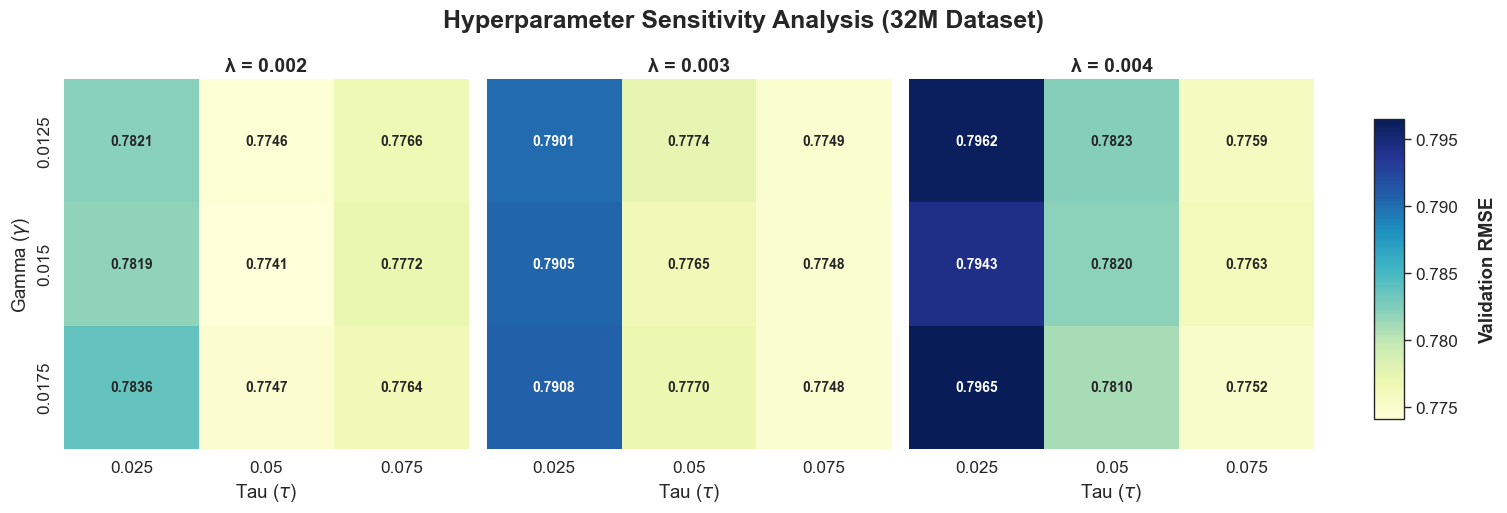

In [112]:
# Final Search Spaces
lambda_grid = np.array([0.002, 0.003, 0.004], dtype=np.float32)
gamma_grid = np.array([0.0125, 0.015, 0.0175], dtype=np.float32)
tau_grid = np.array([0.025, 0.05, 0.075], dtype=np.float32)

results_df, best_params = run_hyperparameter_search(data32m, lambda_grid, gamma_grid, tau_grid)
plot_search_results(results_df)

# 7. Selection of Latent Dimensions (K)

In [79]:
def analyze_k_sensitivity(data_csr, k_values=None, num_iters=10):
    """
    Evaluates model performance across various latent dimensions (K).

    Identifies the 'elbow point' where accuracy gains diminish relative 
    to increased computational complexity. Saves a high-resolution PDF.

    Args:
        data_csr (object): The CSR data object used for training.
        k_values (list): List of latent dimensions to test.
        num_iters (int): Fixed number of iterations for each K test.

    Returns:
        pd.DataFrame: Results containing K, RMSE, and Training Time.
    """
    if k_values is None:
        k_values = [2, 5, 10, 20, 40, 60]

    k_results = []
    print(f"K-Sensitivity Analysis: Evaluating {len(k_values)} dimensions...")

    for k in k_values:
        print(f"Testing K={k:2d}...")
        # Assuming train_als_csr is your optimized JIT training function
        results = train_als_csr(
            data_csr=data_csr,
            K=k,
            num_iters=num_iters,
            verbose=False
        )

        final_val_rmse = results['rmse_test_history'][-1]
        k_results.append({
            'K': k,
            'Validation_RMSE': final_val_rmse,
            'Train_Time': results.get('total_time', 0)
        })
        print(f" >> Validation RMSE: {final_val_rmse:.4f}")

    df_k = pd.DataFrame(k_results)

    # --- ACADEMIC VISUALIZATION ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.figure(figsize=(10, 6))

    # Plot the primary RMSE curve
    plt.plot(
        df_k['K'], df_k['Validation_RMSE'], 
        marker='o', color='#d62728', linewidth=2.5, 
        markersize=9, label='Validation RMSE', zorder=3
    )

    # Add Delta (Gain) annotations to identify diminishing returns
    for i in range(1, len(df_k)):
        x = df_k.iloc[i]['K']
        y = df_k.iloc[i]['Validation_RMSE']
        prev_y = df_k.iloc[i-1]['Validation_RMSE']
        gain = prev_y - y
        
        # Position label above the point
        plt.annotate(
            f'Δ {gain:.4f}',
            xy=(x, y),
            xytext=(0, 12), textcoords='offset points',
            ha='center', fontsize=10, fontweight='bold', color='#7F8C8D'
        )

    # Formatting
    plt.title(
        "Latent Dimension Sensitivity: Identifying Diminishing Returns", 
        fontsize=16, fontweight='bold', pad=20
    )
    plt.xlabel("Latent Dimension (K)", fontsize=13, fontweight='bold')
    plt.ylabel("Validation RMSE", fontsize=13, fontweight='bold')
    
    # Clean-up and Save
    plt.xticks(k_values)
    plt.tight_layout()
    
    output_filename = 'k_sensitivity_analysis.pdf'
    plt.savefig(output_filename, format='pdf', bbox_inches='tight')
    print(f"\nAnalysis complete. Visualization saved as '{output_filename}'")
    plt.show()

    return df_k

K-Sensitivity Analysis: Evaluating 7 dimensions...
Testing K= 0...
 >> Validation RMSE: 0.8548
Testing K= 2...
 >> Validation RMSE: 0.8150
Testing K= 5...
 >> Validation RMSE: 0.7929
Testing K=10...
 >> Validation RMSE: 0.7765
Testing K=20...
 >> Validation RMSE: 0.7683
Testing K=40...
 >> Validation RMSE: 0.7726
Testing K=80...
 >> Validation RMSE: 0.7861

Analysis complete. Visualization saved as 'k_sensitivity_analysis.pdf'


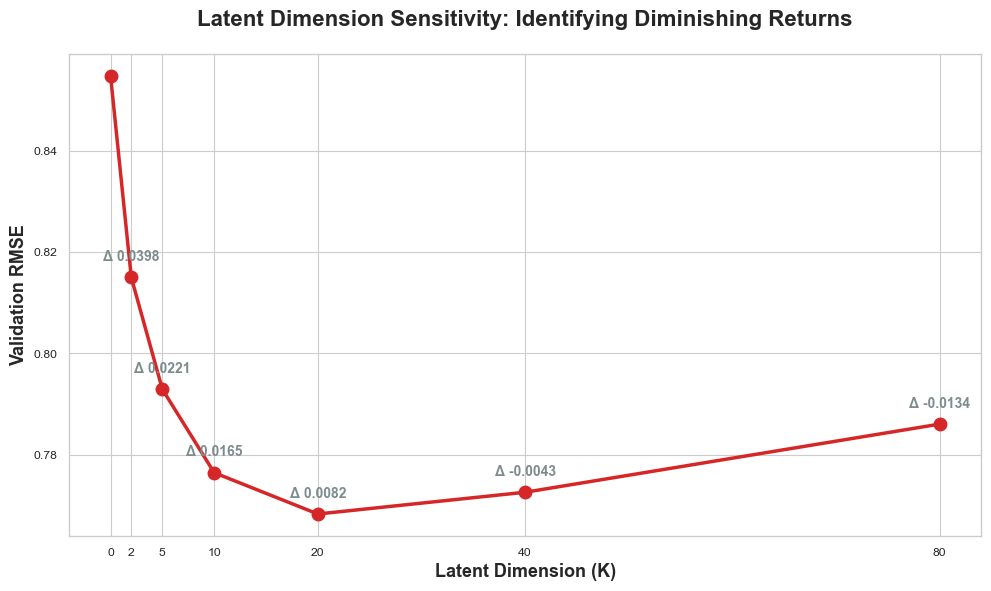

In [80]:
k_df = analyze_k_sensitivity(data32m, k_values=[0, 2, 5, 10, 20, 40, 80])

# 8. Train on 100k Dataset

In [113]:
# @title
results100k = train_als_csr(data_csr=data100k, # CSR structure split data
                           K=20,              # Latent dimensions
                           lambd=0.002,       # Rating weight
                           gamma=0.015,       # Bias regularization
                           tau=0.05,          # Embedding regularization
                           num_iters=30,      # Number of iterations
                           verbose=True)      # Real-time tracking

Starting ALS Training | K=20, λ=0.002, γ=0.015, τ=0.05
Global Mean: 3.4995
Iteration  1/30 | Train RMSE: 0.8396 | Test RMSE: 0.8748
Iteration  5/30 | Train RMSE: 0.8248 | Test RMSE: 0.8644
Iteration 10/30 | Train RMSE: 0.8090 | Test RMSE: 0.8597
Iteration 15/30 | Train RMSE: 0.8021 | Test RMSE: 0.8586
Iteration 20/30 | Train RMSE: 0.7998 | Test RMSE: 0.8582
Iteration 25/30 | Train RMSE: 0.7991 | Test RMSE: 0.8580
Iteration 30/30 | Train RMSE: 0.7987 | Test RMSE: 0.8580
Training Complete. Total Time: 5.83s


FINAL MODEL PARAMETERS (32M):
  User embeddings (P):  (610, 20)
  Item embeddings (Q):  (193609, 20)
  User Biases (bu):     (610,)
  Item Biases (bi):     (193609,)
  Global Mean (μ): 3.4995

  Final Train RMSE:   0.7987
  Final Test RMSE:      0.8580
Generated: 100k_model_nll.pdf


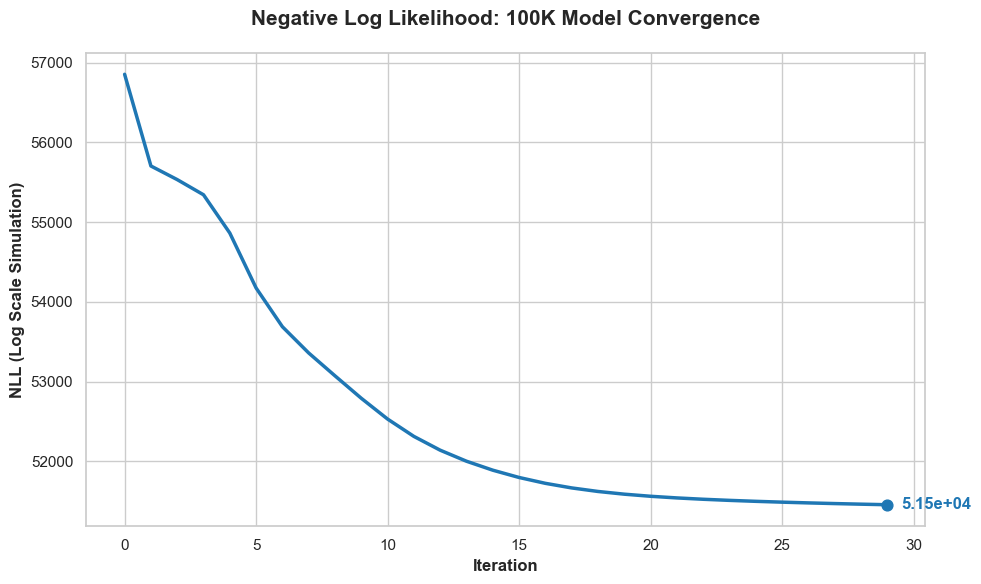

Generated: 100k_model_rmse.pdf


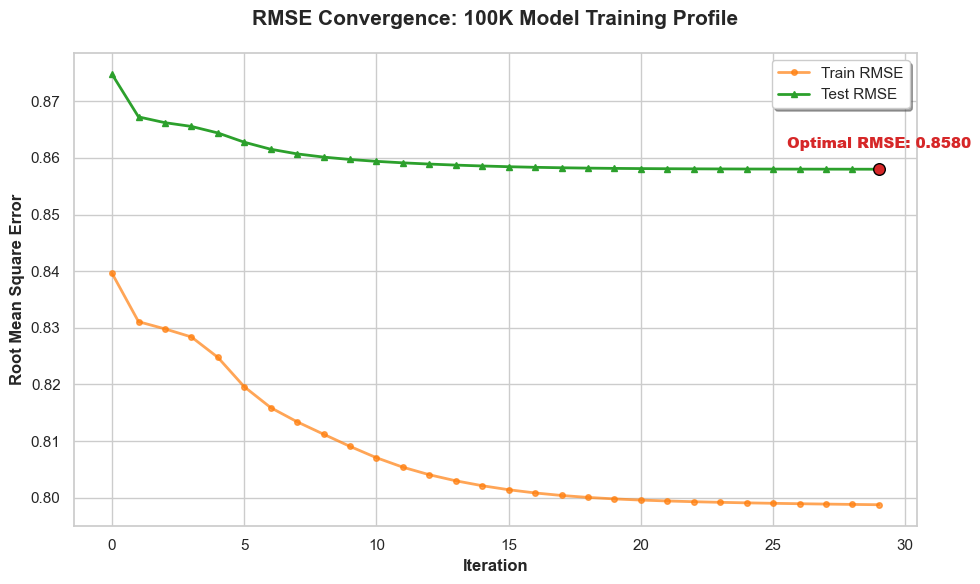

In [114]:
# Extract trained parameters
user_vectors100k = results100k['P']
item_vectors100k = results100k['Q']
user_biases100k  = results100k['bu']
item_biases100k  = results100k['bi']
global_mean100k  = results100k['global_mean']

# SUMMARY STATISTICS
print(f"FINAL MODEL PARAMETERS (32M):")
print(f"  User embeddings (P):  {user_vectors100k.shape}")
print(f"  Item embeddings (Q):  {item_vectors100k.shape}")
print(f"  User Biases (bu):     {user_biases100k.shape}")
print(f"  Item Biases (bi):     {item_biases100k.shape}")
print(f"  Global Mean (\u03bc): {global_mean100k:.4f}")
print(f"\n  Final Train RMSE:   {results100k['rmse_train_history'][-1]:.4f}")
print(f"  Final Test RMSE:      {results100k['rmse_test_history'][-1]:.4f}")

# Plot results
plot_training_results(results100k, model_name="100K Model")

In [115]:
# Save all parameters
np.savez_compressed(
    '100k_model_k20.npz',
    user_vectors=user_vectors100k,
    item_vectors=item_vectors100k,
    user_biases=user_biases100k,
    item_biases=item_biases100k,
    global_mean=global_mean100k,
    K=20,
    n_users=data100k.n_users,
    n_movies=data100k.n_movies
)

print("Model saved to '100k_model_k20.npz'")

Model saved to '100k_model_k20.npz'


# 9. Train on 32m Dataset

In [116]:
# @title
results32m = train_als_csr(data_csr=data32m,  # CSR structure split data
                           K=20,              # Latent dimensions
                           lambd=0.002,       # Rating weight
                           gamma=0.015,       # Bias regularization
                           tau=0.05,          # Embedding regularization
                           num_iters=50,      # Number of iterations
                           verbose=True)      # Real-time tracking

Starting ALS Training | K=20, λ=0.002, γ=0.015, τ=0.05
Global Mean: 3.5404
Iteration  1/50 | Train RMSE: 0.8594 | Test RMSE: 0.8677
Iteration  5/50 | Train RMSE: 0.6983 | Test RMSE: 0.7755
Iteration 10/50 | Train RMSE: 0.6918 | Test RMSE: 0.7691
Iteration 15/50 | Train RMSE: 0.6904 | Test RMSE: 0.7676
Iteration 20/50 | Train RMSE: 0.6898 | Test RMSE: 0.7670
Iteration 25/50 | Train RMSE: 0.6895 | Test RMSE: 0.7667
Iteration 30/50 | Train RMSE: 0.6894 | Test RMSE: 0.7665
Iteration 35/50 | Train RMSE: 0.6893 | Test RMSE: 0.7663
Iteration 40/50 | Train RMSE: 0.6892 | Test RMSE: 0.7662
Iteration 45/50 | Train RMSE: 0.6891 | Test RMSE: 0.7662
Iteration 50/50 | Train RMSE: 0.6891 | Test RMSE: 0.7661
Training Complete. Total Time: 73.04s


FINAL MODEL PARAMETERS (32M):
  User embeddings (P): (200948, 20)
  Item embeddings (Q): (292757, 20)
  User Biases (bu):    (200948,)
  Item Biases (bi):    (292757,)
  Global Mean (μ):    3.5404

  Final Train RMSE:    0.6891
  Final Test RMSE:     0.7661
Generated: 32m_model_nll.pdf


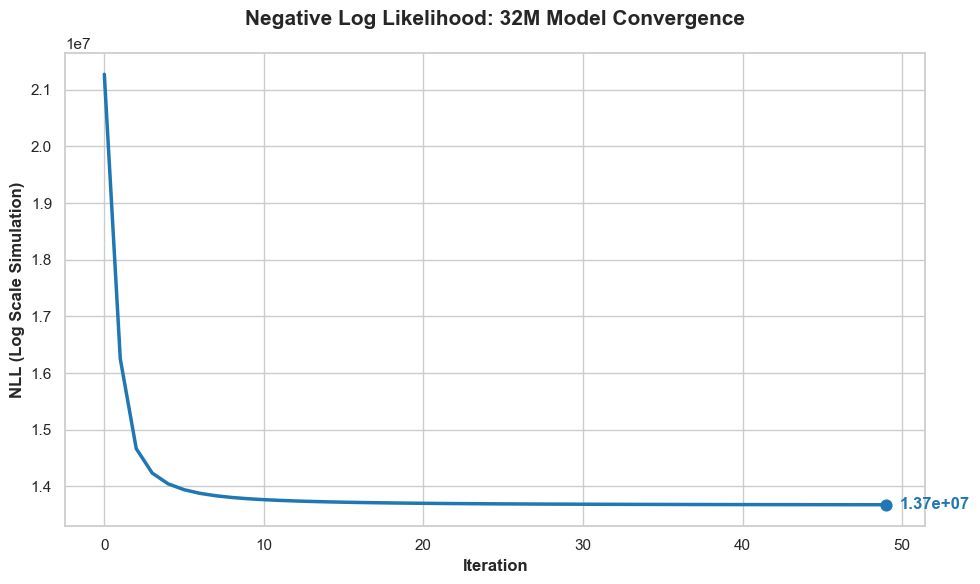

Generated: 32m_model_rmse.pdf


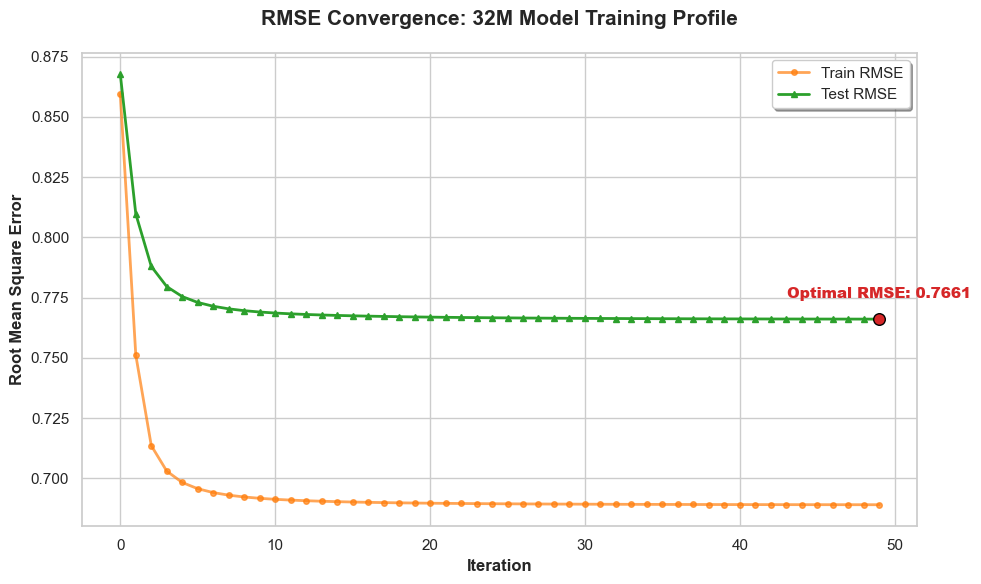

In [119]:
# Extract trained parameters
user_vectors32m = results32m['P']
item_vectors32m = results32m['Q']
user_biases32m  = results32m['bu']
item_biases32m  = results32m['bi']
global_mean32m  = results32m['global_mean']

# SUMMARY STATISTICS
print(f"FINAL MODEL PARAMETERS (32M):")
print(f"  User embeddings (P): {user_vectors32m.shape}")
print(f"  Item embeddings (Q): {item_vectors32m.shape}")
print(f"  User Biases (bu):    {user_biases32m.shape}")
print(f"  Item Biases (bi):    {item_biases32m.shape}")
print(f"  Global Mean (\u03bc):    {global_mean32m:.4f}")
print(f"\n  Final Train RMSE:    {results32m['rmse_train_history'][-1]:.4f}")
print(f"  Final Test RMSE:     {results32m['rmse_test_history'][-1]:.4f}")

# Plot results
plot_training_results(results32m, model_name="32M Model")

In [120]:
# Save all parameters
np.savez_compressed(
    '32m_model_k20.npz',
    user_vectors=user_vectors32m,
    item_vectors=item_vectors32m,
    user_biases=user_biases32m,
    item_biases=item_biases32m,
    global_mean=global_mean32m,
    K=20,
    n_users=data32m.n_users,
    n_movies=data32m.n_movies
)

print("Model saved to '32m_model_k20.npz'")

Model saved to '32m_model_k20.npz'


# 10. Hierarchial Priors ALS with MetaData (Genres)

## ALS Functions

In [121]:
def prepare_genre_metadata(movies_path, n_movies):
    """
    Optimized metadata preparation using static genre mapping.
    Handles 'no genres' cases and provides Numba-ready CSR/CSC formats.
    """
    static_genres = [
        'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
        '(no genres listed)' # Explicitly handle null cases
    ]
    genre_map = {g: i for i, g in enumerate(static_genres)}
    n_genres = len(static_genres)
    
    movie_to_genres = [[] for _ in range(n_movies)]
    
    with open(movies_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader) 
        for row in reader:
            m_idx = int(row[0]) - 1 
            if m_idx >= n_movies or m_idx < 0:
                continue
            
            genres = row[2].split('|')
            for g in genres:
                if g in genre_map:
                    movie_to_genres[m_idx].append(genre_map[g])
                else:
                    movie_to_genres[m_idx].append(genre_map['(no genres listed)'])

    # Build Flattened Arrays (CSR for Metadata)
    movie_genre_start = np.zeros(n_movies + 1, dtype=np.int32)
    movie_to_genres_flat = []
    for i, g_list in enumerate(movie_to_genres):
        movie_genre_start[i] = len(movie_to_genres_flat)
        movie_to_genres_flat.extend(g_list)
    movie_genre_start[n_movies] = len(movie_to_genres_flat)
    
    # Build Reverse Mapping (CSC for Metadata)
    genre_to_movies = [[] for _ in range(n_genres)]
    for m_idx, g_list in enumerate(movie_to_genres):
        for g_idx in g_list:
            genre_to_movies[g_idx].append(m_idx)
            
    genre_movie_start = np.zeros(n_genres + 1, dtype=np.int32)
    genre_to_movies_flat = []
    for i, m_list in enumerate(genre_to_movies):
        genre_movie_start[i] = len(genre_to_movies_flat)
        genre_to_movies_flat.extend(m_list)
    genre_movie_start[n_genres] = len(genre_to_movies_flat)

    return {
        'n_genres': n_genres,
        'movie_to_genres_flat': np.array(movie_to_genres_flat, dtype=np.int32),
        'movie_genre_start': movie_genre_start,
        'genre_to_movies_flat': np.array(genre_to_movies_flat, dtype=np.int32),
        'genre_movie_start': genre_movie_start,
        'idx_to_genre': static_genres
    }

In [122]:
@njit(fastmath=True)
def cholesky_solve(A, b, K):
    """Solve Ax = b using Cholesky decomposition with numerical stability damping."""
    L = np.zeros((K, K), dtype=np.float32)
    for i in range(K):
        for j in range(i + 1):
            s = 0.0
            for k in range(j):
                s += L[i, k] * L[j, k]
            if i == j:
                val = A[i, i] - s
                # Damping factor (1e-6) prevents singular matrix errors in sparse regions
                L[i, j] = np.sqrt(max(val, 1e-6))
            else:
                L[i, j] = (A[i, j] - s) / L[j, j]
    
    y = np.zeros(K, dtype=np.float32)
    for i in range(K):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        y[i] = (b[i] - s) / L[i, i]
        
    x = np.zeros(K, dtype=np.float32)
    for i in range(K - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, K):
            s += L[j, i] * x[j]
        x[i] = (y[i] - s) / L[i, i]
    return x

@njit(parallel=True, fastmath=True)
def compute_movie_priors_numba(N, K, m_to_g_flat, m_g_start, W, Q_prior):
    """Refills Q_prior based on average of genre embeddings."""
    for n in prange(N):
        start, end = m_g_start[n], m_g_start[n+1]
        count = end - start
        if count == 0:
            Q_prior[n].fill(0.0)
            continue
        
        s = np.zeros(K, dtype=np.float32)
        for i in range(start, end):
            s += W[m_to_g_flat[i]]
        Q_prior[n] = s / count

@njit(parallel=True, fastmath=True)
def als_step_item_hierarchical_numba(N, K, item_indptr, item_indices, item_ratings,
                                     P, bu, Q, bi, Q_prior,
                                     lambd, gamma, tau, global_mean):
    """
    Hierarchical Item Update Step.
    Regularizes Q[n] toward the genre-informed prior Q_prior[n].
    """
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    for n in prange(N):
        start, end = item_indptr[n], item_indptr[n+1]
        n_ratings = end - start
        
        if n_ratings == 0:
            Q[n] = Q_prior[n]
            continue

        idx = item_indices[start:end]
        r = item_ratings[start:end]
        U_batch = P[idx]

        # 1. Update Item Bias
        dots = U_batch.dot(Q[n])
        res_bias = r - global_mean - bu[idx] - dots
        bi[n] = (lambd * np.sum(res_bias)) / (lambd * n_ratings + gamma)

        # 2. Update Latent Vector (regularized toward genre prior)
        res_latent = r - global_mean - bu[idx] - bi[n]
        A = lambd * (U_batch.T @ U_batch) + reg_matrix
        b = lambd * (U_batch.T @ res_latent) + (tau * Q_prior[n])
        Q[n] = cholesky_solve(A, b, K)

@njit(parallel=True, fastmath=True)
def als_step_genre_numba(G, K, tau, eta, W, Q, g_to_m_flat, g_m_start):
    """Updates genre embeddings as the precision-weighted average of member movies."""
    for g in prange(G):
        start, end = g_m_start[g], g_m_start[g+1]
        count = end - start
        if count == 0: continue

        denom = tau * count + eta
        num = np.zeros(K, dtype=np.float32)
        for idx in range(start, end):
            num += tau * Q[g_to_m_flat[idx]]
        W[g] = num / denom

In [140]:
def train_hierarchical_als_csr(data_csr, genre_metadata, K=20, lambd=0.002, 
                                 gamma=0.0125, tau=0.05, eta=0.01, 
                                 num_iters=30, verbose=True):
    M, N = data_csr.n_users, data_csr.n_movies
    G = genre_metadata['n_genres']
    dtype = np.float32

    # Initialization
    global_mean = dtype(np.mean(data_csr.user_pairs_train['rating']))
    bu, bi = np.zeros(M, dtype=dtype), np.zeros(N, dtype=dtype)
    P = (np.random.randn(M, K) * 0.01).astype(dtype) 
    Q = (np.random.randn(N, K) * 0.01).astype(dtype)
    W = (np.random.randn(G, K) * 0.01).astype(dtype) 
    Q_prior = np.zeros((N, K), dtype=dtype)

    u_ptr, u_idx, u_r = data_csr.user_indptr_train, data_csr.user_pairs_train['idx'], data_csr.user_pairs_train['rating'].astype(dtype)
    m_ptr, m_idx, m_r = data_csr.movie_indptr_train, data_csr.movie_pairs_train['idx'], data_csr.movie_pairs_train['rating'].astype(dtype)

    history = {'loss_history': [], 'rmse_train_history': [], 'rmse_test_history': []}
    
    start_time = time.time()
    for i in range(num_iters):
        compute_movie_priors_numba(N, K, genre_metadata['movie_to_genres_flat'], 
                                   genre_metadata['movie_genre_start'], W, Q_prior)
        
        als_step_user_numba(M, K, u_ptr, u_idx, u_r, Q, bi, P, bu, lambd, gamma, tau, global_mean)
        
        als_step_item_hierarchical_numba(N, K, m_ptr, m_idx, m_r, P, bu, Q, bi, Q_prior, 
                                         lambd, gamma, tau, global_mean)
        
        als_step_genre_numba(G, K, tau, eta, W, Q, genre_metadata['genre_to_movies_flat'], 
                             genre_metadata['genre_movie_start'])

        # Calculate NLL (Loss) and RMSE
        sse_train, train_rmse = compute_metrics_csr(data_csr, P, Q, bu, bi, global_mean, train=True)
        _, test_rmse = compute_metrics_csr(data_csr, P, Q, bu, bi, global_mean, train=False)

        # UPDATED: Approximation of NLL for plotting
        history['loss_history'].append(sse_train) 
        history['rmse_train_history'].append(train_rmse)
        history['rmse_test_history'].append(test_rmse)

        if verbose and ((i + 1) % 5 == 0 or i == 0):
            print(f"Iteration {i+1:2d}/{num_iters} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

    return {'P': P, 'Q': Q, 'W': W, 'bu': bu, 'bi': bi, 'global_mean': global_mean, **history}

## Train on 32M

In [141]:
# Prepare Metadata using the movie count from your RatingsCSR object
genre_meta = prepare_genre_metadata(movies32m, data32m.n_movies)

In [144]:
# Run Hierarchical Model with optimal parameters
hier_results = train_hierarchical_als_csr(
    data32m, 
    genre_meta, 
    K=20, 
    lambd=0.002, 
    gamma=0.015, 
    tau=0.05, 
    eta=0.01, 
    num_iters=50
)

Iteration  1/50 | Train RMSE: 0.8593 | Test RMSE: 0.8676
Iteration  5/50 | Train RMSE: 0.6975 | Test RMSE: 0.7744
Iteration 10/50 | Train RMSE: 0.6907 | Test RMSE: 0.7680
Iteration 15/50 | Train RMSE: 0.6895 | Test RMSE: 0.7667
Iteration 20/50 | Train RMSE: 0.6890 | Test RMSE: 0.7661
Iteration 25/50 | Train RMSE: 0.6888 | Test RMSE: 0.7658
Iteration 30/50 | Train RMSE: 0.6887 | Test RMSE: 0.7657
Iteration 35/50 | Train RMSE: 0.6886 | Test RMSE: 0.7656
Iteration 40/50 | Train RMSE: 0.6886 | Test RMSE: 0.7655
Iteration 45/50 | Train RMSE: 0.6886 | Test RMSE: 0.7655
Iteration 50/50 | Train RMSE: 0.6886 | Test RMSE: 0.7654


FINAL HIERARCHICAL MODEL PARAMETERS:
  User embeddings (P):  (200948, 20)
  Item embeddings (Q):  (292757, 20)
  Genre embeddings (W): (20, 20)
  User Biases (bu):     (200948,)
  Item Biases (bi):     (292757,)
  Global Mean (μ):      3.5404

  Final Train RMSE:     0.6884
  Final Test RMSE:      0.7654
Generated: 32m_hierarchical_model_nll.pdf


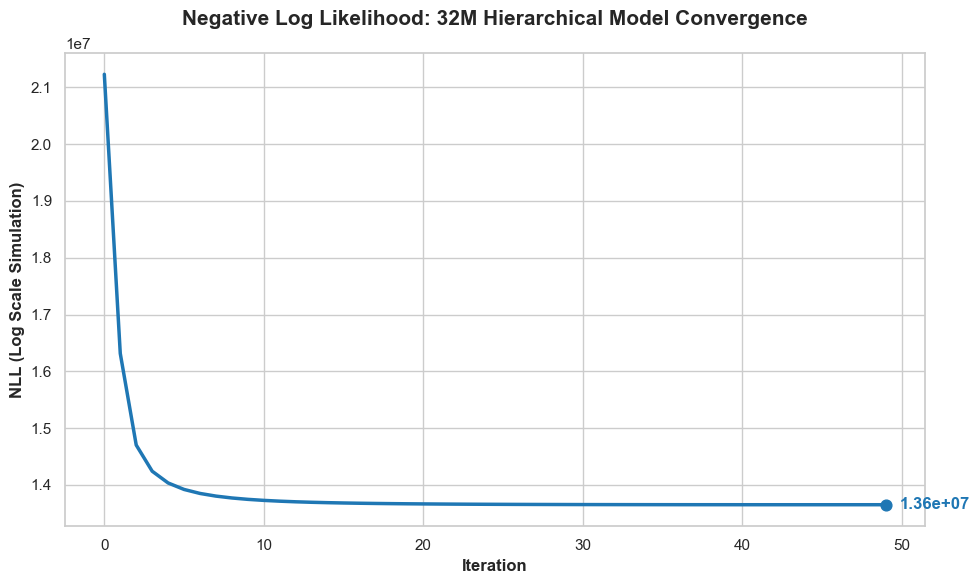

Generated: 32m_hierarchical_model_rmse.pdf


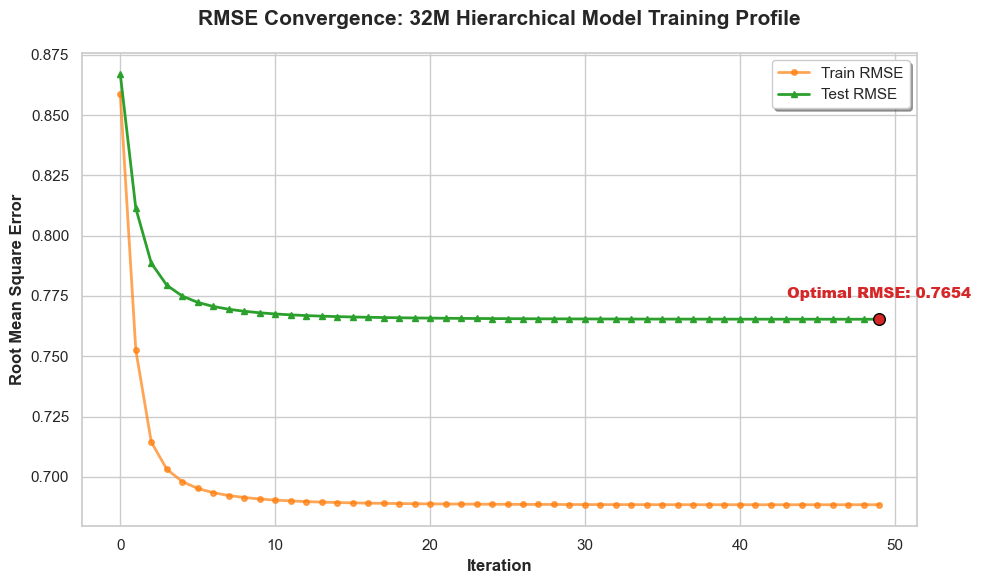

In [143]:
# Extract Hierarchical Model parameters
user_vectors_hier = hier_results['P']
item_vectors_hier = hier_results['Q']
genre_vectors_hier = hier_results['W']
user_biases_hier  = hier_results['bu']
item_biases_hier  = hier_results['bi']
global_mean_hier  = hier_results['global_mean']

# Summary Statistics
print(f"FINAL HIERARCHICAL MODEL PARAMETERS:")
print(f"  User embeddings (P):  {user_vectors_hier.shape}")
print(f"  Item embeddings (Q):  {item_vectors_hier.shape}")
print(f"  Genre embeddings (W): {genre_vectors_hier.shape}")
print(f"  User Biases (bu):     {user_biases_hier.shape}")
print(f"  Item Biases (bi):     {item_biases_hier.shape}")
print(f"  Global Mean (μ):      {global_mean_hier:.4f}")
print(f"\n  Final Train RMSE:     {hier_results['rmse_train_history'][-1]:.4f}")
print(f"  Final Test RMSE:      {hier_results['rmse_test_history'][-1]:.4f}")

# Visualisation
plot_training_results(hier_results, model_name="32M Hierarchical Model")

In [134]:
# Save Model Parameters
# Including the genre matrix 'W' and metadata dimensions
np.savez_compressed(
    '32m_hierarchical_model_k20.npz',
    user_vectors=user_vectors_hier,
    item_vectors=item_vectors_hier,
    genre_vectors=genre_vectors_hier,
    user_biases=user_biases_hier,
    item_biases=item_biases_hier,
    global_mean=global_mean_hier,
    K=20,
    n_users=data32m.n_users,
    n_movies=data32m.n_movies,
    n_genres=genre_meta['n_genres']
)

print("\nHierarchical model saved to '32m_hierarchical_model_k20.npz'")


Hierarchical model saved to '32m_hierarchical_model_k20.npz'


# 11. Recommendations and Polarisation Analysis

In [136]:
# New User liked Toy Story
toy_story = 0
lotr_1 = 4992
lotr_2 = 5951
lotr_3 = 7152
seed_ratings = [(toy_story, 5.0)]

u_vec, u_bias = recommend_for_new_user(seed_ratings,
                                       item_vectors_hier,
                                       item_biases_hier,
                                       global_mean_hier,
                                       data32m,
                                       movies)

RECOMMENDATIONS FOR NEW USER (1 Seed Ratings)
Calculated Bias: 0.1372 | Vector Norm: 0.0980

 1. [Score: 4.1260] Toy Story 2 (1999)
    Genres: Adventure|Animation|Children|Comedy|Fantasy

 2. [Score: 4.0930] Monsters, Inc. (2001)
    Genres: Adventure|Animation|Children|Comedy|Fantasy

 3. [Score: 4.0905] Finding Nemo (2003)
    Genres: Adventure|Animation|Children|Comedy

 4. [Score: 4.0627] Toy Story 3 (2010)
    Genres: Adventure|Animation|Children|Comedy|Fantasy|IMAX

 5. [Score: 4.0390] Incredibles, The (2004)
    Genres: Action|Adventure|Animation|Children|Comedy

 6. [Score: 4.0331] Up (2009)
    Genres: Adventure|Animation|Children|Drama

 7. [Score: 4.0164] WALL·E (2008)
    Genres: Adventure|Animation|Children|Romance|Sci-Fi

 8. [Score: 4.0109] Shrek (2001)
    Genres: Adventure|Animation|Children|Comedy|Fantasy|Romance

 9. [Score: 4.0030] Aladdin (1992)
    Genres: Adventure|Animation|Children|Comedy|Musical

10. [Score: 4.0023] Lion King, The (1994)
    Genres: Adventure

In [132]:
most_polar, least_polar = analyze_movie_polarity(item_vectors_hier,
                                                 data32m,
                                                 movies,
                                                 top_k=10,
                                                 min_ratings=1000)

MOST POLARIZING MOVIES (Min Ratings: 1,000)

 1. [Norm: 10.5721] Lord of the Rings: The Return of the King, The (2003) (67,449 ratings)
    Genres: Action|Adventure|Drama|Fantasy

 2. [Norm: 10.5382] Lord of the Rings: The Fellowship of the Ring, The (2001) (73,122 ratings)
    Genres: Adventure|Fantasy

 3. [Norm: 10.3966] Lord of the Rings: The Two Towers, The (2002) (67,463 ratings)
    Genres: Adventure|Fantasy

 4. [Norm: 9.4120] Star Wars: Episode IV - A New Hope (1977) (85,010 ratings)
    Genres: Action|Adventure|Sci-Fi

 5. [Norm: 9.0961] Dumb & Dumber (Dumb and Dumber) (1994) (36,802 ratings)
    Genres: Adventure|Comedy

 6. [Norm: 8.9124] Star Wars: Episode V - The Empire Strikes Back (1980) (72,151 ratings)
    Genres: Action|Adventure|Sci-Fi

 7. [Norm: 8.7859] Star Wars: Episode I - The Phantom Menace (1999) (37,973 ratings)
    Genres: Action|Adventure|Sci-Fi

 8. [Norm: 8.7638] Star Wars: Episode VI - Return of the Jedi (1983) (67,496 ratings)
    Genres: Action|Advent

# 12. 2D Embeddings of Item Vectors

In [96]:
# Load 'k=2' hierarchical model parameters
model_data = np.load('32m_model_k2.npz')

item_vectors32m_k2 = model_data['item_vectors']

print("Model loaded successfully:")
print(f"Item embeddings shape: {item_vectors32m_k2.shape}")

Model loaded successfully:
Item embeddings shape: (292757, 2)


In [97]:
def plot_embedding_space(item_vectors, movies_df, data_csr,
                         num_movies_to_plot=2000,
                         highlight_genres=None):
    """
    Visualizes the item embedding space using PCA and saves as a PDF.

    If the latent dimension K is 2, the factors are plotted directly.
    If K > 2, PCA is used to project the vectors into a 2D plane.
    """
    if highlight_genres is None:
        highlight_genres = ['Children', 'Horror', 'Documentary', 'Action', 'Sci-Fi']

    # 1. Filter for Top-Rated Movies to reduce noise
    print(f"Filtering for top {num_movies_to_plot} most-rated movies...")
    counts = data_csr.get_movie_rating_counts()
    top_indices = np.argsort(counts)[::-1][:num_movies_to_plot]
    vectors_top = item_vectors[top_indices]

    # 2. Dimensionality Reduction
    k_dim = item_vectors.shape[1]
    if k_dim == 2:
        print("Detected K=2. Plotting latent factors directly.")
        projections = vectors_top
        x_label, y_label = "Latent Factor 1", "Latent Factor 2"
        title_prefix = "Direct Latent Space"
    else:
        print(f"Detected K={k_dim}. Applying PCA for 2D projection...")
        pca = PCA(n_components=2, random_state=42)
        projections = pca.fit_transform(vectors_top)
        x_label, y_label = "Principal Component 1", "Principal Component 2"
        title_prefix = "PCA Projection"

    # 3. Efficient Metadata Mapping
    movies_indexed = movies_df.set_index('movieId')
    plot_data = []

    for i, original_idx in enumerate(top_indices):
        mid = original_idx + 1
        try:
            row = movies_indexed.loc[mid]
            genres_str = row['genres']

            category = 'Other'
            for g in highlight_genres:
                if g in genres_str:
                    category = g
                    break

            plot_data.append({
                'x': projections[i, 0],
                'y': projections[i, 1],
                'Category': category,
                'Title': row['title']
            })
        except KeyError:
            continue

    df_plot = pd.DataFrame(plot_data)

    # 4. Academic Visualization
    plt.figure(figsize=(14, 10))
    sns.set_theme(style="whitegrid", context="paper")

    # Custom Palette Logic
    unique_cats = [g for g in highlight_genres if g in df_plot['Category'].unique()]
    palette = dict(zip(unique_cats, sns.color_palette("tab10", len(unique_cats))))
    palette['Other'] = '#d3d3d3'

    # Layer 1: Other background items
    sns.scatterplot(
        data=df_plot[df_plot['Category'] == 'Other'],
        x='x', y='y', color=palette['Other'],
        s=25, alpha=0.3, linewidth=0, label='Other'
    )

    # Layer 2: Highlighted genres on top
    sns.scatterplot(
        data=df_plot[df_plot['Category'] != 'Other'],
        x='x', y='y', hue='Category', palette=palette,
        hue_order=unique_cats, s=70, alpha=0.9, 
        edgecolor='white', linewidth=0.5
    )

    

    # Formatting
    plt.title(
        f"{title_prefix} of Item Embedding Space (Top Interactions)", 
        fontsize=18, fontweight='bold', pad=20
    )
    plt.xlabel(x_label, fontsize=13, fontweight='bold')
    plt.ylabel(y_label, fontsize=13, fontweight='bold')

    # FIX: Remove title_fontweight and set it on the title object instead
    leg = plt.legend(
        bbox_to_anchor=(1.02, 1), loc='upper left', 
        borderaxespad=0, title="Genre Group"
    )
    leg.get_title().set_fontweight('bold')

    # Reference axes
    plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.2)
    plt.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.2)

    plt.tight_layout()

    # Save as PDF
    output_filename = 'embedding_space.pdf'
    plt.savefig(output_filename, format='pdf', bbox_inches='tight')
    print(f"Visualization saved as '{output_filename}'")
    plt.show()

Filtering for top 2500 most-rated movies...
Detected K=2. Plotting latent factors directly.
Visualization saved as 'embedding_space.pdf'


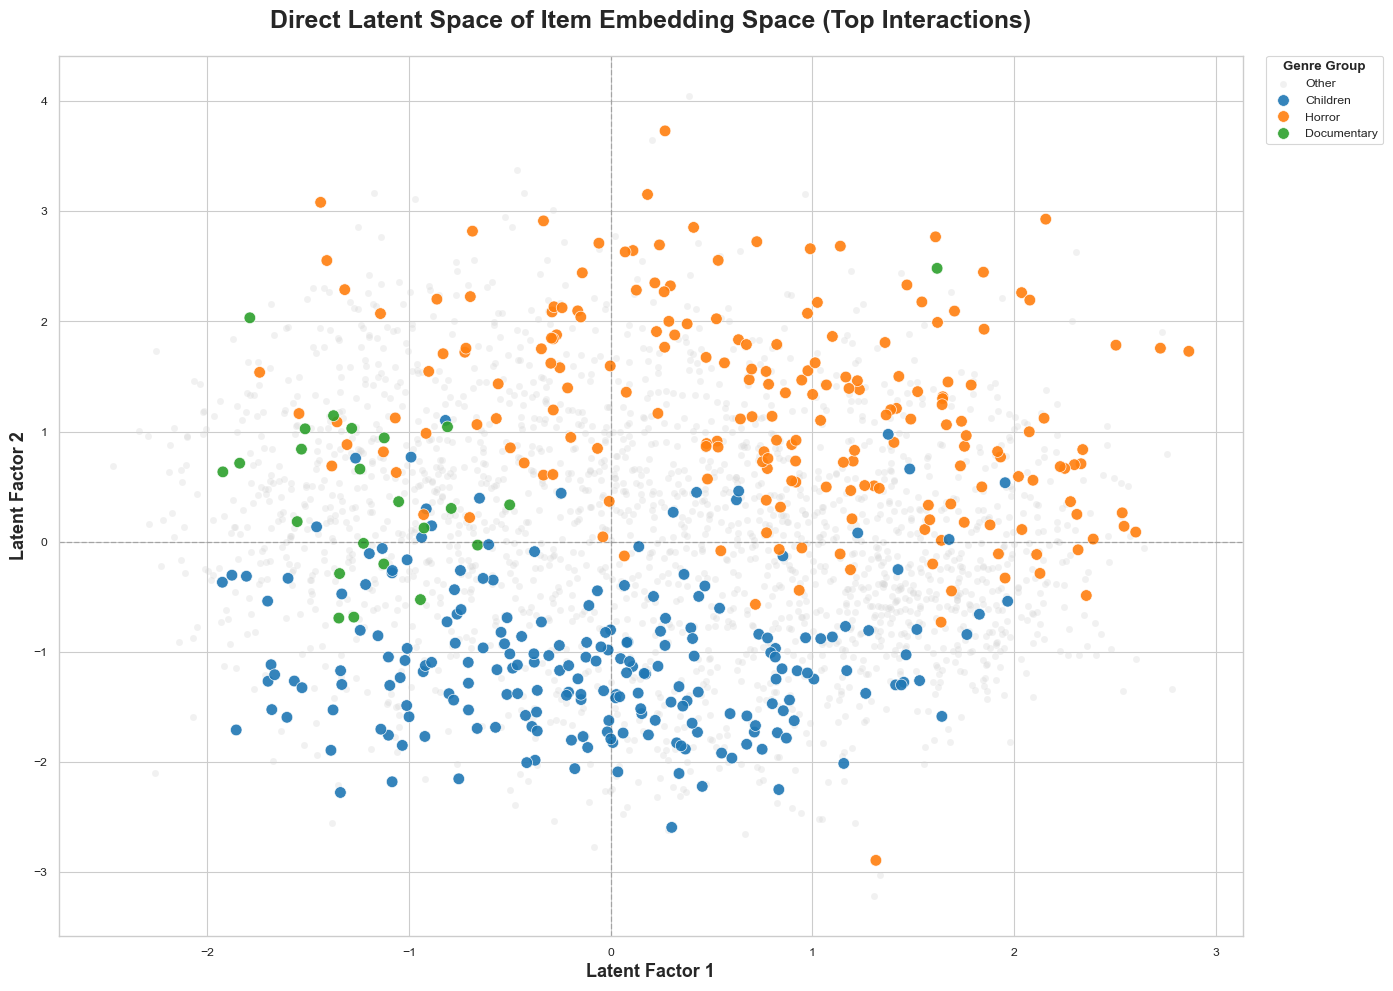

In [98]:
plot_embedding_space(item_vectors = item_vectors32m_k2,
                     movies_df = movies,
                     data_csr = data32m,
                     num_movies_to_plot = 2500,
                     highlight_genres = ['Children', 'Horror', 'Documentary'])

# 13. Performance Benchmarks

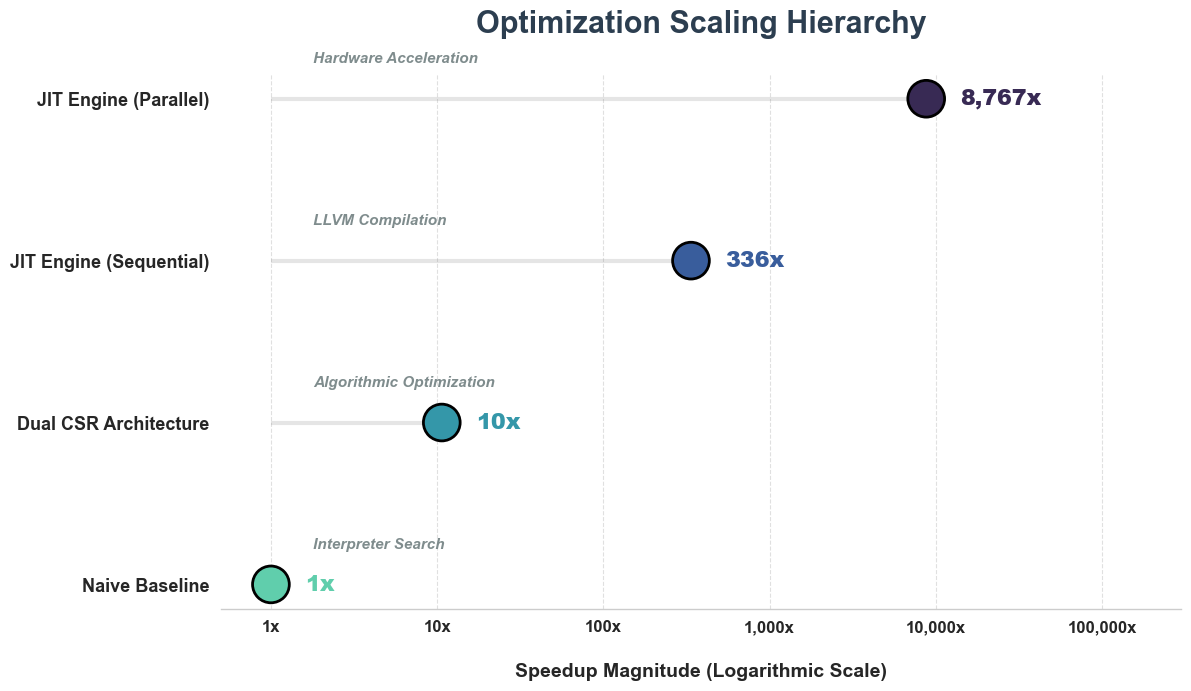

In [137]:
# Data (Verified i7-14650HX benchmarks)
data = {
    'Stage': ['Naive Baseline', 'Dual CSR Architecture', 'JIT Engine (Sequential)', 'JIT Engine (Parallel)'],
    'Time': [12800, 1200, 38, 1.46],
    'Mechanism': ['Interpreter Search', 'Algorithmic Optimization', 'LLVM Compilation', 'Hardware Acceleration']
}

df = pd.DataFrame(data)
df['Speedup'] = df.iloc[0]['Time'] / df['Time']

# FINAL VISUALIZATION
sns.set_theme(style="whitegrid", context="paper")
fig, ax = plt.subplots(figsize=(12, 7))
colors = sns.color_palette("mako_r", len(df))

# 1. Plot the "Stems"
ax.hlines(y=df['Stage'], xmin=1.0, xmax=df['Speedup'], color='gray', alpha=0.2, linewidth=3, zorder=1)

# 2. Plot the "Lollipops" (bubbles)
ax.scatter(df['Speedup'], df['Stage'], color=colors, s=700, edgecolors='black', linewidth=2, zorder=2)

# 3. Add Labels with precise offsets
for i, row in df.iterrows():
    # Mechanism Label: Offset to 1.8 to ensure zero overlap with the axis labels
    ax.text(1.8, i + 0.22, row['Mechanism'], 
            fontsize=11, color='#7F8C8D', fontstyle='italic', fontweight='bold')
    
    # Speedup Text: Multiplier at 1.6 for clear breathing room
    ax.text(row['Speedup'] * 1.6, i, f"{int(row['Speedup']):,}x", 
            va='center', fontsize=16, fontweight='black', color=colors[i])

# 4. Styling & Log Scale
ax.set_xscale("log")
ax.set_xlim(0.5, 300000) 

# Centralized Brief Title
ax.set_title('Optimization Scaling Hierarchy', 
             fontsize=22, fontweight='bold', pad=30, loc='center', color='#2C3E50')

ax.set_xlabel('Speedup Magnitude (Logarithmic Scale)', fontsize=14, fontweight='bold', labelpad=20)
ax.set_ylabel('')

# Clean up axes
sns.despine(left=True, bottom=False)
ax.xaxis.grid(True, linestyle='--', alpha=0.6)
ax.yaxis.grid(False) 

# Tick formatting
plt.xticks([1, 10, 100, 1000, 10000, 100000], 
           ['1x', '10x', '100x', '1,000x', '10,000x', '100,000x'], 
           fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('performance_hierarchy.pdf', format='pdf', bbox_inches='tight')
plt.show()